In [ ]:
import os
import sys
import argparse
import numpy as np
import imageio.v2 as iio
import imageio.v3 as iio
from skimage import img_as_float32
from skimage.transform import resize
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pywt
import csv
import cv2
from typing import Tuple, List, Dict
import zipfile
import gdown
import requests

In [ ]:
# Download file from Google Drive
url = "https://drive.google.com/uc?export=download&id=1X4VjzuX4uPs3_Z0rgTPcOeqE2GWRA0Z2"
output_path = "medical_MRI_CT.zip"

r = requests.get(url)
with open(output_path, 'wb') as f:
    f.write(r.content)

# Unzip the file
extract_path = "./"
with zipfile.ZipFile(output_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


Found 16 image(s).


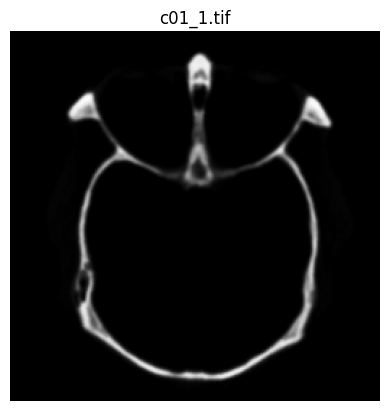

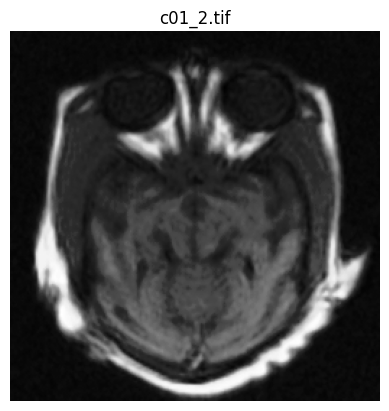

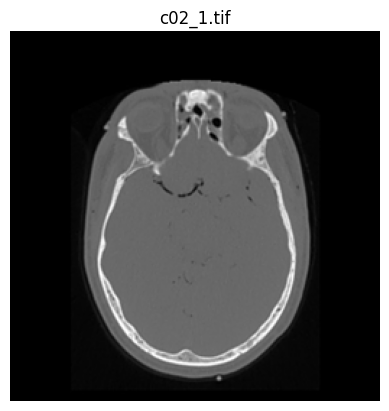

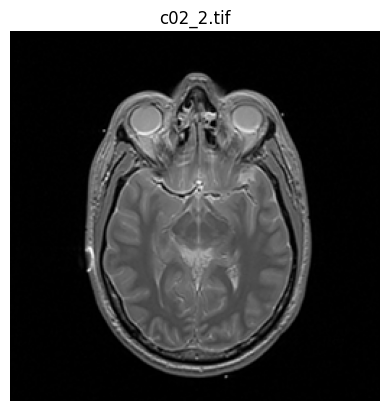

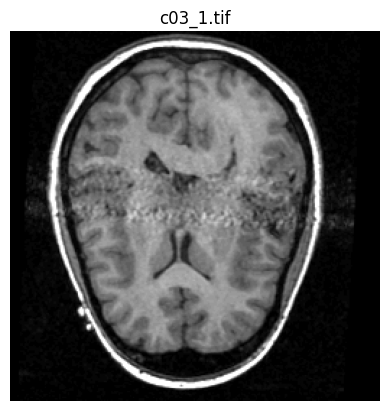

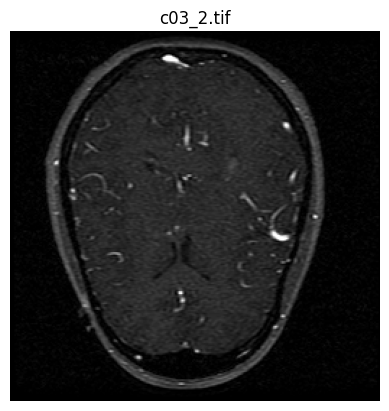

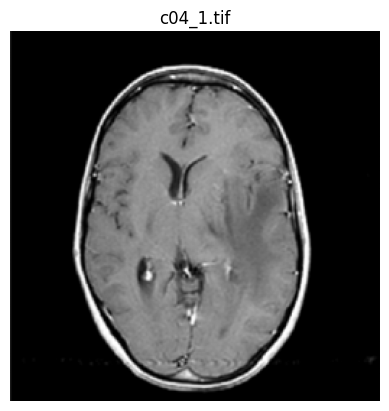

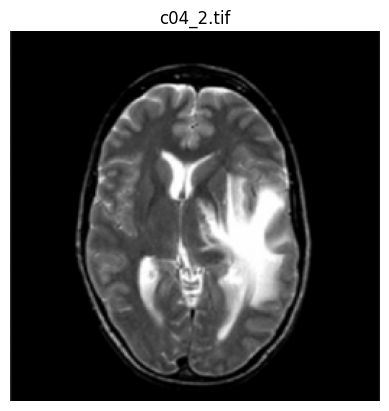

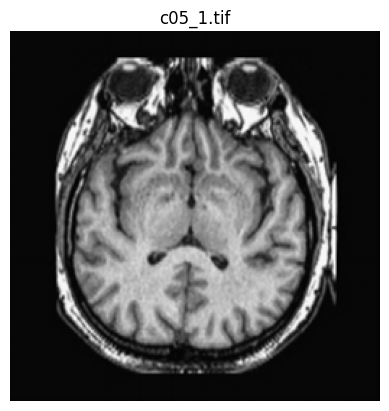

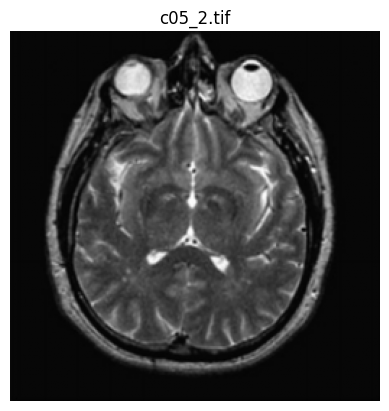

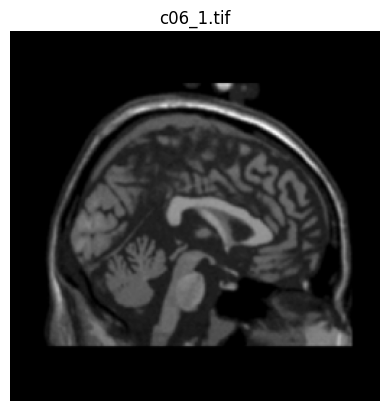

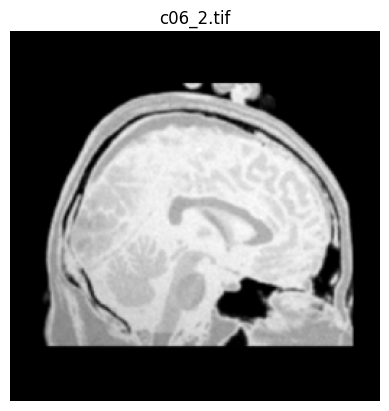

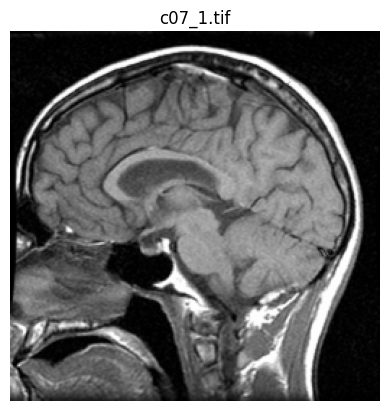

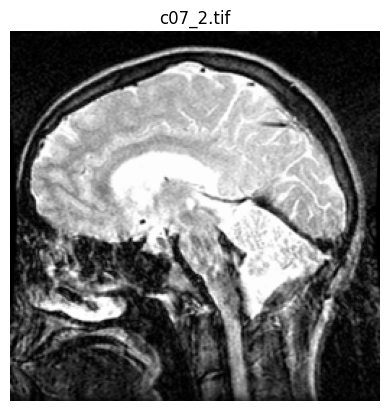

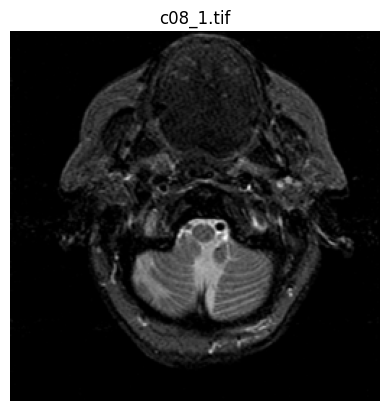

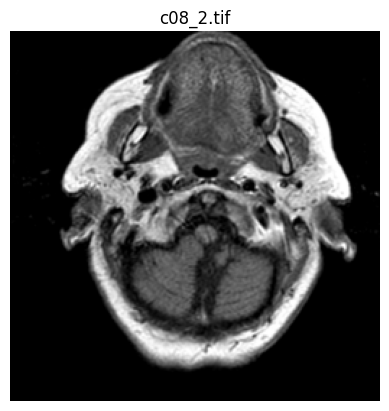

In [ ]:
# path to the folder containing images
folder_path = "/content/medical"
image_files = sorted([f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.tif', '.jpeg'))])

# print the number of images found
print(f"Found {len(image_files)} image(s).")

# display the images
for img_file in image_files:
    img_path = os.path.join(folder_path, img_file)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.imshow(img, cmap='gray')
    plt.title(img_file)
    plt.axis('off')
    plt.show()

In [ ]:
DATA_DIR = '/content/medical'
OUT_DIR = '/content/fused_results'
WAVELETS = ['sym4', 'db1', 'coif1', 'bior4.4']
LEVELS = [1, 2, 3]
LOW_W_MRI = 0.9

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Batch SWT fusion for paired MRI/CT images.
Layout expected:
  medical/
    c01_1.tif
    c01_2.tif
    ...
    c08_1.tif
    c08_2.tif

Usage (Colab/CLI):
  pip install numpy pywavelets scikit-image imageio
  python swt_fusion_batch.py --data_dir /content/medical --out_dir /content/fused_results \
       --wavelets sym4 db1 coif1 bior4.4 --levels 1 2 3 --low_w_mri 0.9

Notes:
- If sizes differ slightly, images are resized to the first image in the pair.
- The script tries to identify MRI vs CT; it also evaluates both assignments and keeps the better fusion by MI+SSIM score.
"""

def to_gray01(arr: np.ndarray) -> np.ndarray:
    arr = arr.astype(np.float32)
    if arr.ndim == 3:
        if arr.shape[2] == 4:
            arr = arr[..., :3]
        r, g, b = arr[...,0], arr[...,1], arr[...,2]
        arr = 0.2126*r + 0.7152*g + 0.0722*b
    # robust scale to [0,1]
    p1, p99 = np.percentile(arr, [1, 99])
    if p99 > p1:
        arr = np.clip((arr - p1) / (p99 - p1), 0, 1)
    else:
        arr = np.clip(arr, 0, 1)
    return img_as_float32(arr)

def mutual_information(x: np.ndarray, y: np.ndarray, bins: int=64) -> float:
    # x,y in [0,1]
    x = (np.clip(x,0,1)*255).astype(np.uint8)
    y = (np.clip(y,0,1)*255).astype(np.uint8)
    h, _, _ = np.histogram2d(x.ravel(), y.ravel(), bins=bins)
    pxy = h / (h.sum() + 1e-12)
    px = pxy.sum(axis=1, keepdims=True)
    py = pxy.sum(axis=0, keepdims=True)
    nz = pxy > 0
    # compute MI safely
    mi = 0.0
    for i in range(pxy.shape[0]):
        for j in range(pxy.shape[1]):
            if pxy[i,j] > 0 and px[i,0] > 0 and py[0,j] > 0:
                mi += pxy[i,j] * (np.log(pxy[i,j]) - np.log(px[i,0]) - np.log(py[0,j]))
    return float(mi)

def swt_fusion(mri: np.ndarray, ct: np.ndarray, wavelet: str='sym4', level: int=2, low_w_mri: float=0.9) -> np.ndarray:
    # inputs are float32 [0,1]
    # coeffs_m = pywt.swt2(mri, wavelet=wavelet, level=level, trim_approx=True)
    # coeffs_c = pywt.swt2(ct,  wavelet=wavelet, level=level, trim_approx=True)
    coeffs_m = pywt.swt2(mri, wavelet=wavelet, level=level, trim_approx=False)
    coeffs_c = pywt.swt2(ct,  wavelet=wavelet, level=level, trim_approx=False)

    fused_coeffs = []
    for (cA_m, (cH_m, cV_m, cD_m)), (cA_c, (cH_c, cV_c, cD_c)) in zip(coeffs_m, coeffs_c):
        cA_f = low_w_mri * cA_m + (1.0 - low_w_mri) * cA_c
        # detail by max-abs
        cH_f = np.where(np.abs(cH_m) >= np.abs(cH_c), cH_m, cH_c)
        cV_f = np.where(np.abs(cV_m) >= np.abs(cV_c), cV_m, cV_c)
        cD_f = np.where(np.abs(cD_m) >= np.abs(cD_c), cD_m, cD_c)
        fused_coeffs.append((cA_f, (cH_f, cV_f, cD_f)))
    fused = pywt.iswt2(fused_coeffs, wavelet=wavelet)
    return np.clip(fused, 0, 1).astype(np.float32)

def guess_ct_vs_mri(a: np.ndarray, b: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Heuristic: CT tends to have more very bright pixels and sharper skull edges.
    We'll use high-percentile intensity and gradient magnitude proxy."""
    from scipy.ndimage import sobel
    def score_ct(x):
        p99 = np.percentile(x, 99.5)
        frac_hi = (x > 0.9).mean()
        gx = sobel(x, axis=0)
        gy = sobel(x, axis=1)
        edge = np.mean(np.hypot(gx, gy))
        return 0.5*p99 + 0.4*frac_hi + 0.1*edge
    sA = score_ct(a); sB = score_ct(b)
    if sA >= sB:
        ct, mri = a, b
    else:
        ct, mri = b, a
    return ct, mri

def resize_to_match(img: np.ndarray, ref: np.ndarray) -> np.ndarray:
    if img.shape == ref.shape:
        return img
    return resize(img, ref.shape, order=1, preserve_range=True, anti_aliasing=True).astype(np.float32)

def process_pair(imgA: np.ndarray, imgB: np.ndarray, wavelet: str, level: int, low_w_mri: float) -> Tuple[np.ndarray, Dict[str,float], Dict[str,float]]:
    # Ensure grayscale [0,1] and same size
    a = to_gray01(imgA); b = to_gray01(imgB)
    b = resize_to_match(b, a)
    # Guess modalities
    ct, mri = guess_ct_vs_mri(a, b)
    # Evaluate both assignments: (mri,ct) and swapped
    fused1 = swt_fusion(mri, ct, wavelet=wavelet, level=level, low_w_mri=low_w_mri)
    fused2 = swt_fusion(ct, mri, wavelet=wavelet, level=level, low_w_mri=low_w_mri)  # swapped
    # Metrics
    def metrics(fused, mri_ref, ct_ref):
        mi_mri = mutual_information(fused, mri_ref)
        mi_ct  = mutual_information(fused, ct_ref)
        ssim_m = ssim(fused, mri_ref, data_range=1.0)
        ssim_c = ssim(fused, ct_ref,  data_range=1.0)
        score = float(0.6*(mi_mri+mi_ct) + 0.4*(ssim_m+ssim_c))
        return {'MI_MRI': mi_mri, 'MI_CT': mi_ct, 'SSIM_MRI': float(ssim_m), 'SSIM_CT': float(ssim_c), 'Score': score}
    m1 = metrics(fused1, mri, ct)
    m2 = metrics(fused2, mri, ct)  # compare to same refs
    if m2['Score'] > m1['Score']:
        return fused2, m2, {'assigned_mri':'imgB' if (mri is b) else 'imgA', 'assigned_ct':'imgA' if (ct is a) else 'imgB', 'swapped': True}
    else:
        return fused1, m1, {'assigned_mri':'imgA' if (mri is a) else 'imgB', 'assigned_ct':'imgB' if (ct is b) else 'imgA', 'swapped': False}

def find_pairs(data_dir: str) -> List[Tuple[str,str,str]]:
    files = [f for f in os.listdir(data_dir) if f.lower().endswith(('.tif','.tiff','.png','.jpg','.jpeg'))]
    # group by prefix before underscore, e.g., c01 from c01_1.tif
    groups: Dict[str,List[str]] = {}
    for f in files:
        key = f.split('_')[0]
        groups.setdefault(key, []).append(f)
    pairs = []
    for key, lst in groups.items():
        lst = sorted(lst)  # ensures _1 before _2 typically
        if len(lst) >= 2:
            pairs.append((key, lst[0], lst[1]))
    pairs.sort()
    return pairs

Coloring images

In [ ]:

def apply_false_color(img, cmap_name='jet'):
    """Apply false color mapping to a grayscale image."""
    if len(img.shape) == 3:
        img = np.mean(img, axis=2)  # convert to grayscale if needed
    img_norm = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
    cmap = cm.get_cmap(cmap_name)
    img_colored = cmap(img_norm)[:, :, :3]
    return (img_colored * 255).astype(np.uint8)


def _normalize_swt2_coeffs(coeffs):
    """
    Normalize various possible pywt.swt2 return formats into a list of
    (cA, (cH, cV, cD)) tuples.

    Handles nested tuples/lists/dicts and common stacked-array formats.
    Raises ValueError if it cannot understand the structure.
    """
    normalized = []
    for idx, level_item in enumerate(coeffs):
        arrays = []

        def collect(x):
            # recursively collect numpy arrays inside nested containers
            if isinstance(x, np.ndarray):
                arrays.append(x)
            elif isinstance(x, (list, tuple)):
                for e in x:
                    collect(e)
            elif isinstance(x, dict):
                for v in x.values():
                    collect(v)
            else:
                # ignore other types
                pass

        collect(level_item)

        if len(arrays) >= 4:
            # common case: arrays = [cA, cH, cV, cD, ...]
            cA = arrays[0]
            cH = arrays[1]
            cV = arrays[2]
            cD = arrays[3]
        elif len(arrays) == 2:
            # second array may be stacked details: shape (3,H,W) or (H,W,3)
            cA = arrays[0]
            detail = arrays[1]
            if detail.ndim == 3 and detail.shape[0] == 3:
                cH, cV, cD = detail[0], detail[1], detail[2]
            elif detail.ndim == 3 and detail.shape[2] == 3:
                cH, cV, cD = detail[:, :, 0], detail[:, :, 1], detail[:, :, 2]
            else:
                raise ValueError(f"Unrecognized detail-array shape at level {idx}: {detail.shape}")
        else:
            # as a last resort, try to interpret if level_item itself is a 2-tuple but inner detail has arrays in other layout
            # try mapping keys if it's a mapping-like structure
            raise ValueError(f"Could not parse swt2 coefficients at level {idx}. Found {len(arrays)} arrays.")

        normalized.append((cA, (cH, cV, cD)))
    return normalized


def swt_fusion(mri: np.ndarray, ct: np.ndarray, wavelet: str='sym4',
               level: int=2, low_w_mri: float=0.9) -> np.ndarray:
    """
    Robust SWT fusion wrapper that normalizes coeff formats before fusing.
    Inputs:
      - mri, ct: 2D numpy arrays (grayscale), values can be [0..1] or [0..255]
    Returns fused image as float32 in [0,1].
    """
    # convert to float [0,1]
    mri_f = mri.astype(np.float32)
    ct_f  = ct.astype(np.float32)
    if mri_f.max() > 1.0:
        mri_f /= 255.0
    if ct_f.max() > 1.0:
        ct_f /= 255.0

    # get coefficients (don't rely on trim_approx shape; we'll normalize)
    coeffs_m = pywt.swt2(mri_f, wavelet=wavelet, level=level)
    coeffs_c = pywt.swt2(ct_f,  wavelet=wavelet, level=level)

    coeffs_m = _normalize_swt2_coeffs(coeffs_m)
    coeffs_c = _normalize_swt2_coeffs(coeffs_c)

    fused_coeffs = []
    for (cA_m, (cH_m, cV_m, cD_m)), (cA_c, (cH_c, cV_c, cD_c)) in zip(coeffs_m, coeffs_c):
        cA_f = low_w_mri * cA_m + (1.0 - low_w_mri) * cA_c
        cH_f = np.where(np.abs(cH_m) >= np.abs(cH_c), cH_m, cH_c)
        cV_f = np.where(np.abs(cV_m) >= np.abs(cV_c), cV_m, cV_c)
        cD_f = np.where(np.abs(cD_m) >= np.abs(cD_c), cD_m, cD_c)
        fused_coeffs.append((cA_f, (cH_f, cV_f, cD_f)))

    fused = pywt.iswt2(fused_coeffs, wavelet=wavelet)
    fused = np.clip(fused, 0.0, 1.0).astype(np.float32)
    return fused


def evaluate_fusion(fused, mri, ct):
    """Dummy scoring function (replace with MI/SSIM if implemented)."""
    score = np.var(fused)  # Using variance as a placeholder
    return score

def find_pairs(data_dir):
    """Find matching MRI/CT image pairs in the dataset."""
    files = sorted([f for f in os.listdir(data_dir) if f.lower().endswith('.tif')])
    pairs = []
    for i in range(0, len(files), 2):
        if i+1 < len(files):
            key = files[i][:4]
            pairs.append((key, files[i], files[i+1]))
    return pairs

In [ ]:
sys.argv = [
    '',
    '--data_dir', '/content/medical',
    '--out_dir', '/content/fused_results',
    '--wavelets', 'sym4','db1','coif1','bior4.4',
    '--levels', '1','2','3',
    '--low_w_mri', '0.9'
]

/tmp/ipython-input-4085642104.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


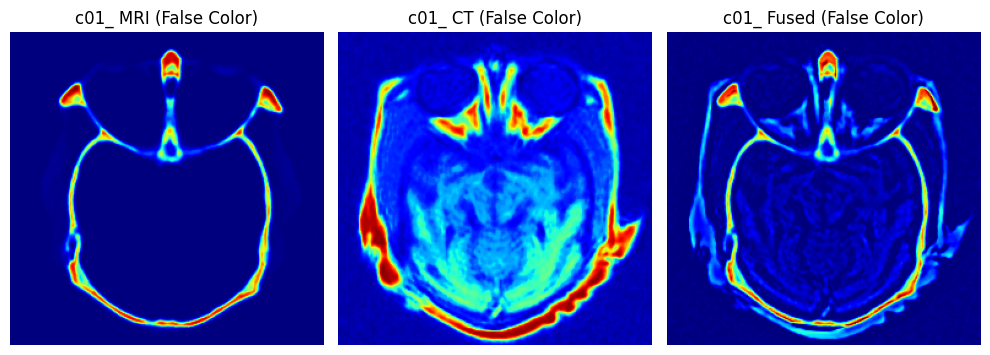

Best for c01_: Wavelet=db1, Level=3, Score=0.0205


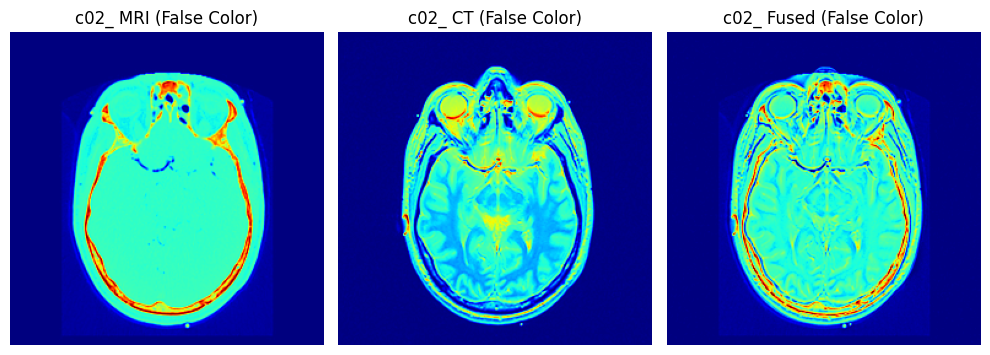

Best for c02_: Wavelet=db1, Level=3, Score=0.0508


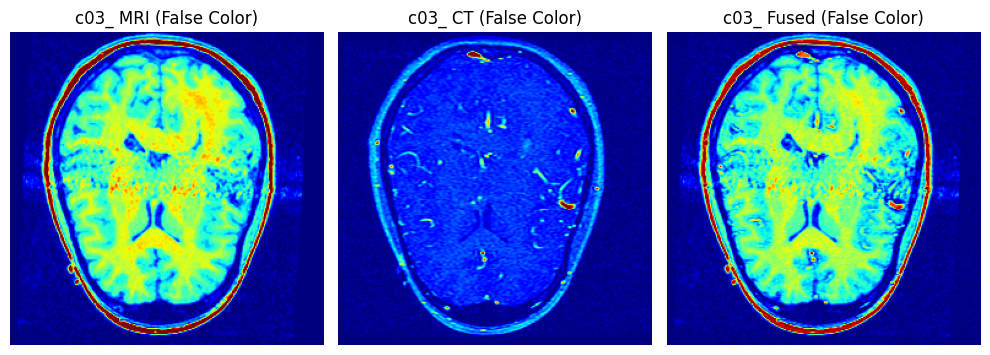

Best for c03_: Wavelet=db1, Level=3, Score=0.0665


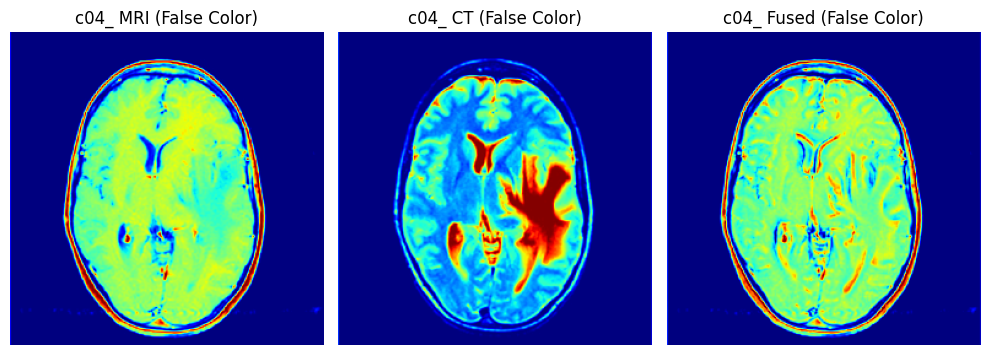

Best for c04_: Wavelet=db1, Level=3, Score=0.0706


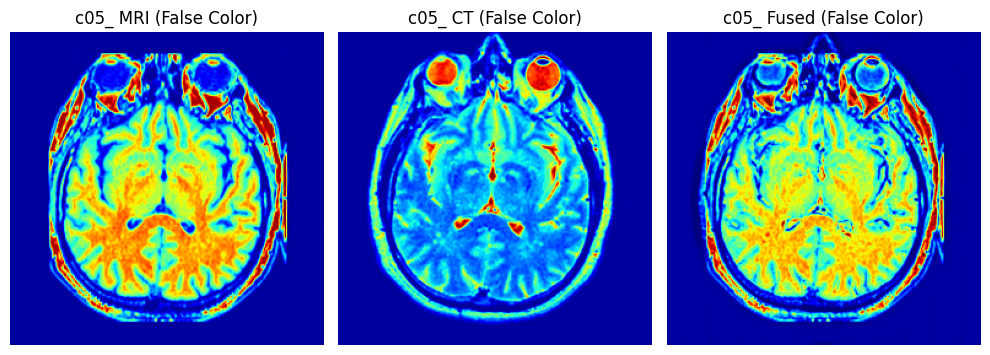

Best for c05_: Wavelet=db1, Level=3, Score=0.0746


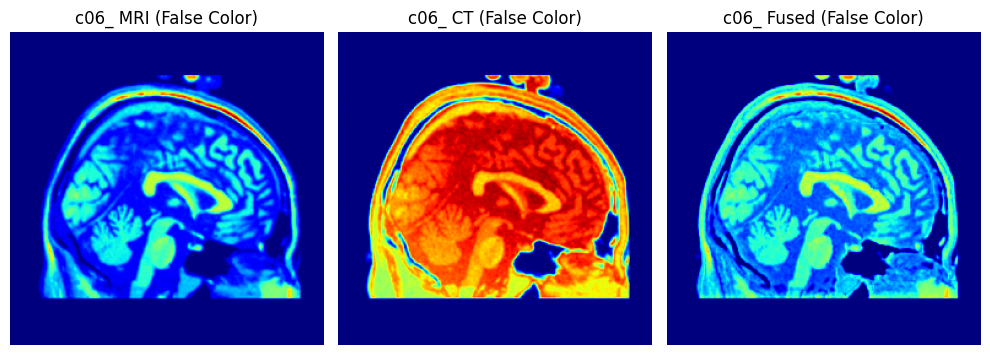

Best for c06_: Wavelet=db1, Level=3, Score=0.0297


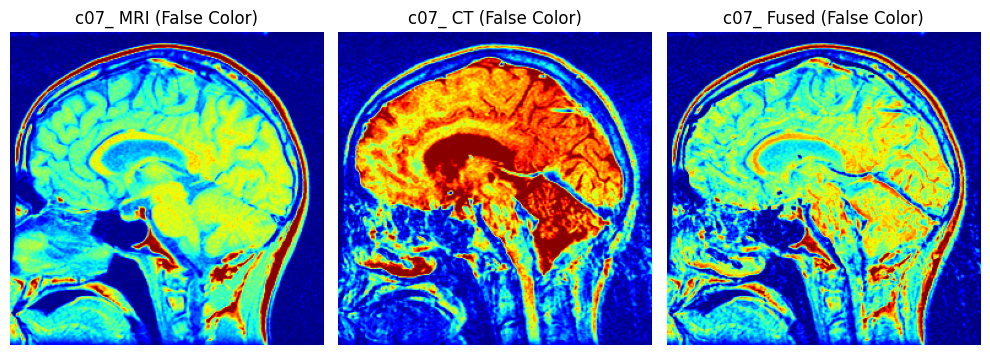

Best for c07_: Wavelet=db1, Level=3, Score=0.0694


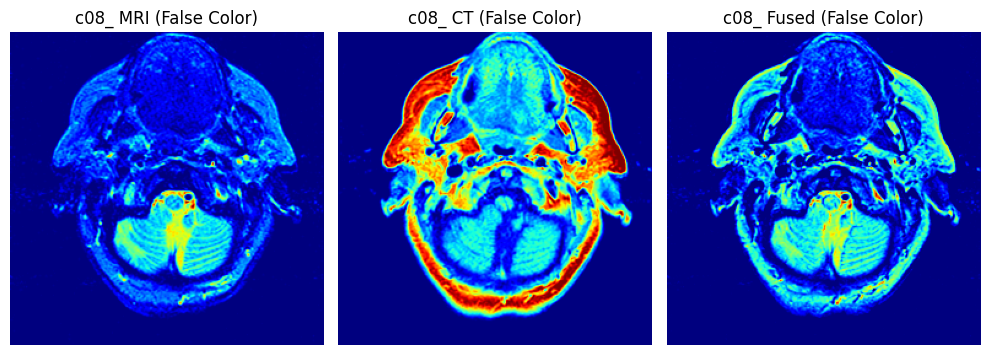

Best for c08_: Wavelet=db1, Level=3, Score=0.0234


In [ ]:
def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_dir', required=True)
    parser.add_argument('--out_dir', required=True)
    parser.add_argument('--wavelets', nargs='+', default=['sym4','db1','coif1','bior4.4'])
    parser.add_argument('--levels', nargs='+', type=int, default=[1,2,3])
    parser.add_argument('--low_w_mri', type=float, default=0.9)
    args = parser.parse_args()

    os.makedirs(args.out_dir, exist_ok=True)
    pairs = find_pairs(args.data_dir)
    if not pairs:
        print('No pairs found.')
        return

    for key, f1, f2 in pairs:
        p1 = os.path.join(args.data_dir, f1)
        p2 = os.path.join(args.data_dir, f2)
        img1 = iio.imread(p1)
        img2 = iio.imread(p2)

        best_score = -1
        best_fused = None
        best_params = None

        for wave in args.wavelets:
            for lvl in args.levels:
                fused = swt_fusion(img1, img2, wave, lvl, args.low_w_mri)
                score = evaluate_fusion(fused, img1, img2)
                if score > best_score:
                    best_score = score
                    best_fused = fused
                    best_params = (wave, lvl)

        fused_uint8 = (best_fused * 255).astype(np.uint8)
        out_path = os.path.join(args.out_dir, f"fused_{key}.png")
        iio.imwrite(out_path, fused_uint8)

        # Apply false coloring
        mri_colored = apply_false_color(img1, 'jet')
        ct_colored = apply_false_color(img2, 'jet')
        fused_colored = apply_false_color(fused_uint8, 'jet')

        # Save false color versions
        iio.imwrite(os.path.join(args.out_dir, f"mri_{key}_color.png"), mri_colored)
        iio.imwrite(os.path.join(args.out_dir, f"ct_{key}_color.png"), ct_colored)
        iio.imwrite(os.path.join(args.out_dir, f"fused_{key}_color.png"), fused_colored)

        # Plot results
        fig, ax = plt.subplots(1, 3, figsize=(10, 4))
        ax[0].imshow(mri_colored)
        ax[0].set_title(f"{key} MRI (False Color)")
        ax[0].axis("off")

        ax[1].imshow(ct_colored)
        ax[1].set_title(f"{key} CT (False Color)")
        ax[1].axis("off")

        ax[2].imshow(fused_colored)
        ax[2].set_title(f"{key} Fused (False Color)")
        ax[2].axis("off")

        plt.tight_layout()
        plt.show()

        print(f"Best for {key}: Wavelet={best_params[0]}, Level={best_params[1]}, Score={best_score:.4f}")

if __name__ == '__main__':
    main()